In [1]:
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from eggman.grid import luminosity, log_surface_gravity, calculate_eep, metallicity
from eggman.grid.defaults import MASS, YINI, ZINI, AGE, TEFF, RAD, DNUF, AMLT

import tensorflow as tf

print(f"Using TensorFlow {tf.__version__}")

DIR = "/mnt/data-storage/stellar-emulator/train"
FILENAME = "/mnt/data-storage/yaguangli2023/stellar-models/grid_models_surface_effect_uncorrected/grid.h5"

RSTATE = 0
EEP = "EEP"
PHASE = "phase"
LUM = "L"
GRAV = "g"
LOG = "log"
SEP = "_"

print(f"Loading grid data from '{FILENAME}'.")
tracks = pd.read_hdf(FILENAME, "tracks")
stars = pd.read_hdf(FILENAME, "stars")
data = tracks.join(stars).dropna().reset_index()
data.head()

2024-02-01 12:01:37.826093: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-01 12:01:37.851208: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-01 12:01:37.851227: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-01 12:01:37.852237: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-01 12:01:37.857138: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-01 12:01:37.857509: I tensorflow/core/platform/cpu_feature_guard.cc:1

Using TensorFlow 2.15.0
Loading grid data from '/mnt/data-storage/yaguangli2023/stellar-models/grid_models_surface_effect_uncorrected/grid.h5'.


,track,star,star_mass,Yinit,Zinit,amlt,fov_core,fov_shell,star_age,radius,Teff,center_h1,log_LHe,log_Lnuc,Dnu_freq_o,eps_o,delta_Pg
0,7000,1,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,2.220454e+07,0.893151,6382.509287,0.718192,-45.291905,0.078416,148.565794,1.129515,0.0
1,7000,2,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,2.300916e+07,0.891027,6377.312552,0.718122,-45.308912,0.077135,149.148739,1.131800,0.0
2,7000,3,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,2.397470e+07,0.890320,6373.785487,0.718037,-45.328570,0.075916,149.362908,1.132830,0.0
3,7000,4,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,3.019433e+07,0.893682,6371.412400,0.717474,-45.392646,0.075178,148.552167,1.130613,0.0
4,7000,5,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,3.259691e+07,0.894573,6371.453759,0.717253,-45.402736,0.075810,148.331713,1.129892,0.0


In [2]:
data["kron"] = data["star_age"] * data["star_mass"]**3.2
data["log_kron"] = np.log10(data["kron"])
data["M_H"] = metallicity(data)

In [3]:
from isochrones.mist.bc import MISTBolometricCorrectionGrid
from isochrones.interp import DFInterpolator

Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


In [4]:
print("Preprocessing data.")
# Create log10 quantities
for key in [ZINI, AGE, TEFF, RAD, DNUF, MASS]:
    data[SEP.join([LOG, key])] = np.log10(data[key])

data[SEP.join([LOG, GRAV])] = log_surface_gravity(data)
data[SEP.join([LOG, LUM])] = np.log10(luminosity(data))

# Drop bad tracks
with open("../notebook/central_hydrogen_problem_tracks.txt") as file:
    bad = list(map(int, file.read().split(",")))

data = data.drop(index=data[data.track.isin(bad)].index)

print("Calculating EEP.")
# Add EEP and drop pre-MS and post log_g cutoff
keys = [SEP.join([LOG, key]) for key in [TEFF, LUM]]
primary, secondary = calculate_eep(data, keys, alpha=0.5, boundaries=["zams", "end"])
data[PHASE] = primary
data[EEP] = secondary

data = data.drop(index=data[data.phase == -1].index)

Preprocessing data.
Calculating EEP.


In [5]:
BANDS = ["G", "BP", "RP"]

bc_grid = MISTBolometricCorrectionGrid(BANDS)
bc_grid.df.head()

G        BP        RP
Teff   logg [Fe/H] Av                                
2500.0 -4.0 -4.0   0.00 -2.181987 -4.652549 -0.881256
                   0.05 -2.211638 -4.697705 -0.909058
                   0.10 -2.241241 -4.742843 -0.936830
                   0.15 -2.270798 -4.787964 -0.964572
                   0.20 -2.300307 -4.833067 -0.992286

In [6]:
bc_interpolator = DFInterpolator(bc_grid.df.xs(0.00, level="Av"))

In [7]:
data[["Teff", "log_g", "M_H"]]

,Teff,log_g,M_H
4,6371.453759,4.500174,-0.852135
5,6371.395675,4.499387,-0.852135
6,6371.047385,4.497885,-0.852135
7,6370.652426,4.496376,-0.852135
8,6370.549143,4.494823,-0.852135
...,...,...,...
6587233,4192.969247,2.277606,0.487831
6587234,4176.349466,2.244528,0.487831
6587235,4170.127283,2.232024,0.487831
6587236,4164.145786,2.219796,0.487831


In [8]:
bcs = bc_interpolator(data[["Teff", "log_g", "M_H"]].to_numpy().T)

In [9]:
bol_mag_sun = 4.75
data["bol_mag"] = bol_mag_sun - 2.5 * data.log_L

In [10]:
for i, band in enumerate(BANDS):
    data[f"abs_{band}"] = data["bol_mag"] - bcs[:, i]

In [11]:
bp_rp = bcs[:, 2] - bcs[:, 1]

In [12]:
np.allclose(data.abs_BP - data.abs_RP, bp_rp)

True

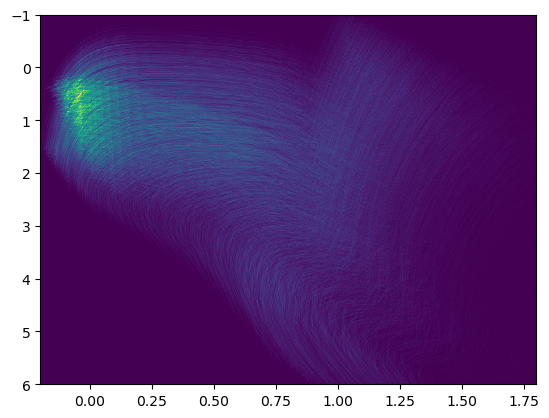

In [13]:
fig, ax = plt.subplots()

ax.hist2d(bp_rp, data["abs_G"], bins=500, range=[[-0.2, 1.8], [-1.0, 6.0]])
ax.invert_yaxis()

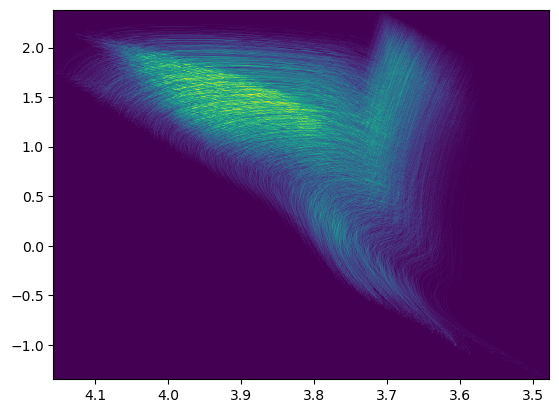

In [14]:
fig, ax = plt.subplots()

ax.hist2d(data["log_Teff"], data["log_L"], bins=500)
ax.invert_xaxis()

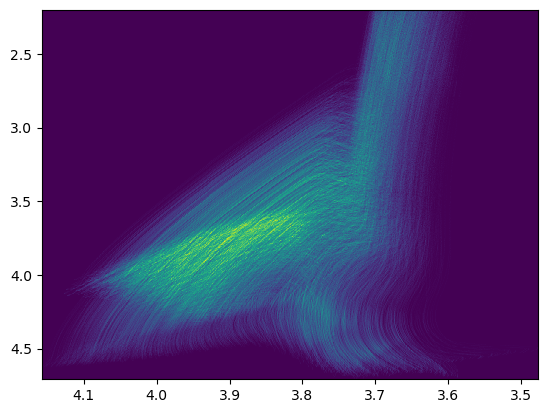

In [15]:
fig, ax = plt.subplots()

ax.hist2d(data["log_Teff"], data["log_g"], bins=500)
ax.invert_xaxis()
ax.invert_yaxis()

In [16]:
print("Preparing train and test dataset.")
train = data.sample(frac=0.8, random_state=RSTATE)
test = data.drop(index=train.index)

Preparing train and test dataset.


In [17]:
filename = "/mnt/data-storage/yaguangli2023/stellar-models/grid_models_surface_effect_uncorrected/dataset.h5"
train.to_hdf(filename, "train")
test.to_hdf(filename, "test")

In [18]:
from scipy.spatial import KDTree
from scipy.stats import truncnorm
import seaborn as sns

In [238]:
features = ["EEP", "star_mass", "M_H", "Yinit", "amlt"]
labels = ["log_star_age", "log_Teff", "log_radius", "log_Dnu_freq_o"]

In [260]:
df = data

In [261]:
loc = df[features].mean(0).to_numpy()
scale = df[features].std(0).to_numpy()
# loc = df[features].min(0).to_numpy()
# scale =  df[features].max(0).to_numpy() - loc

In [262]:
tree = KDTree((df[features] - loc) / scale)

In [263]:
size = (10000, len(features))
rng = np.random.default_rng()

# log_evol, log_mass, [M/H], Y_scaled, a_MLT
xmin = np.array([-np.inf, np.log10(0.7), -0.9, -np.inf, 1.3])
xmax = np.array([0.0, np.log10(2.3), 0.4, np.inf, 2.7])

mu = np.array([-0.7, 0.0, 0.0, 0.0, 2.0])
sigma = np.array([0.4, 0.2, 0.5, 1.0, 0.08])

x = truncnorm.rvs((xmin - mu)/sigma, (xmax-mu)/sigma, mu, sigma, size=size, random_state=rng)

In [264]:
dydz = 1.5
y0 = 0.247
sigma_y = 0.008

log_zx_sun = np.log10(0.0181)

f = dydz / (10**-(x[:, 2] + log_zx_sun) + 1)
mu_y = (y0 + f) / (1 + f)

x[:, :2] = 10**x[:, :2]
x[:, 3] *= sigma_y
x[:, 3] += mu_y

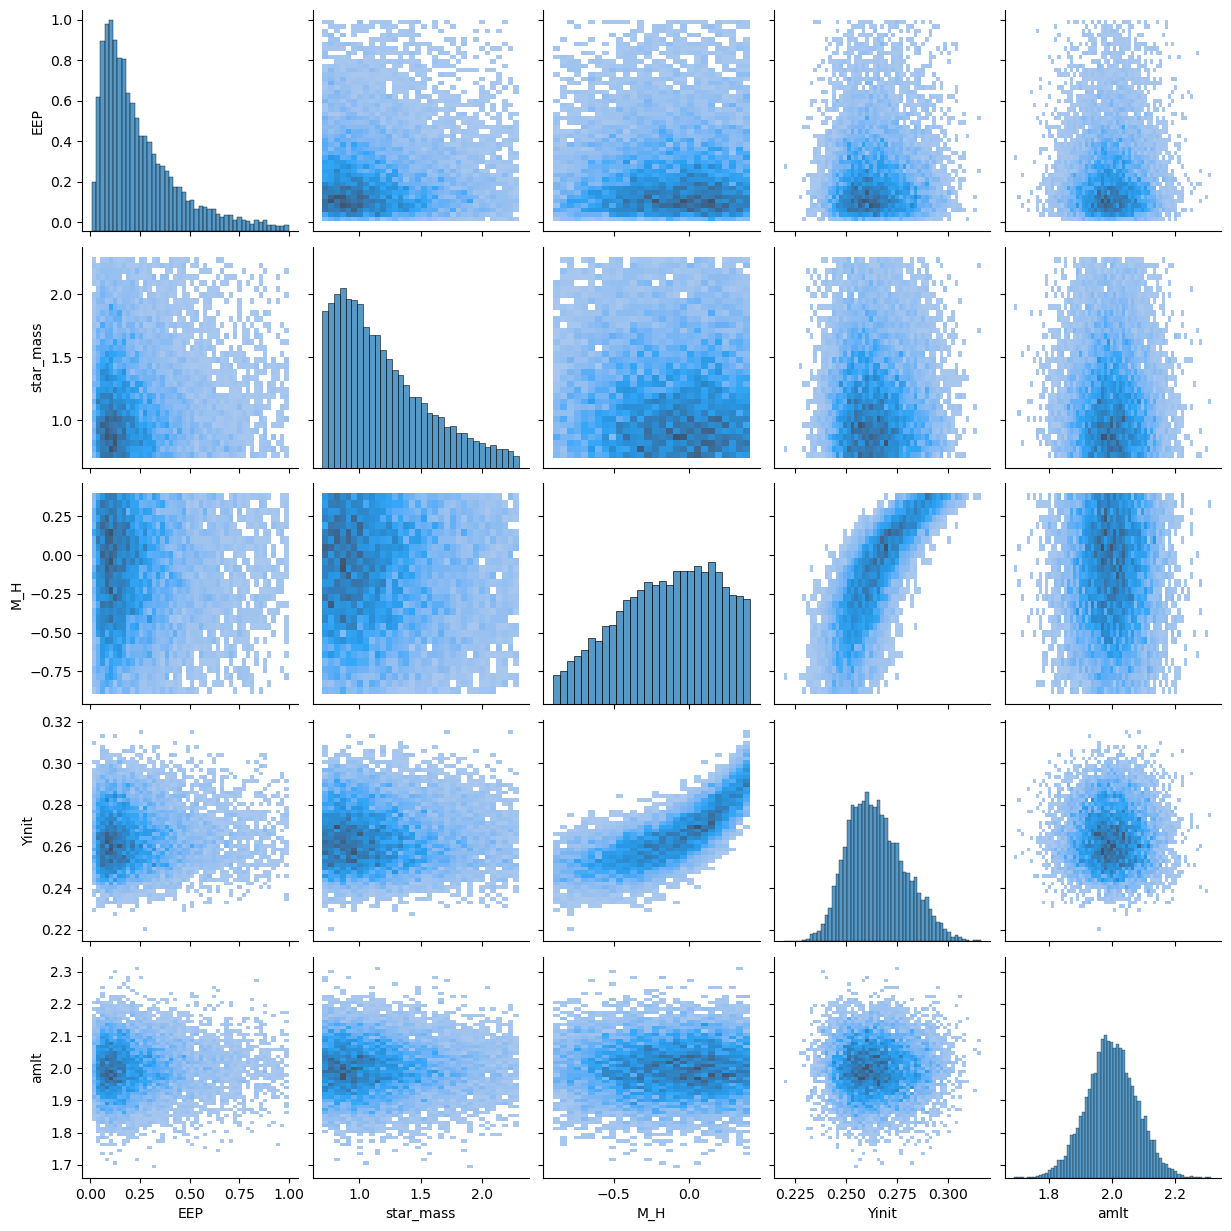

In [265]:
sns.pairplot(pd.DataFrame(x, columns=features), kind="hist", diag_kind="hist");

In [266]:
x_scaled = (x - loc) / scale
dist, i = tree.query(x_scaled)

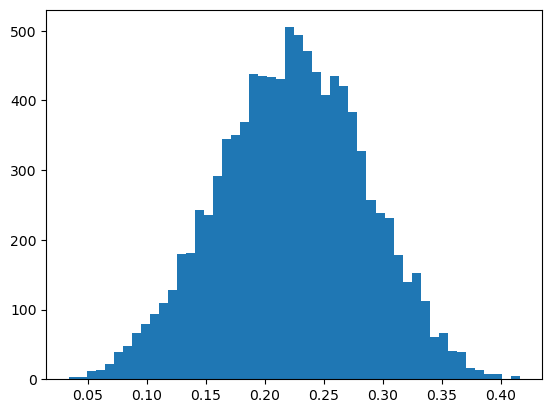

In [267]:
fig, ax = plt.subplots()
ax.hist(dist, bins=50);

In [268]:
features_error = df[features].iloc[i] - x

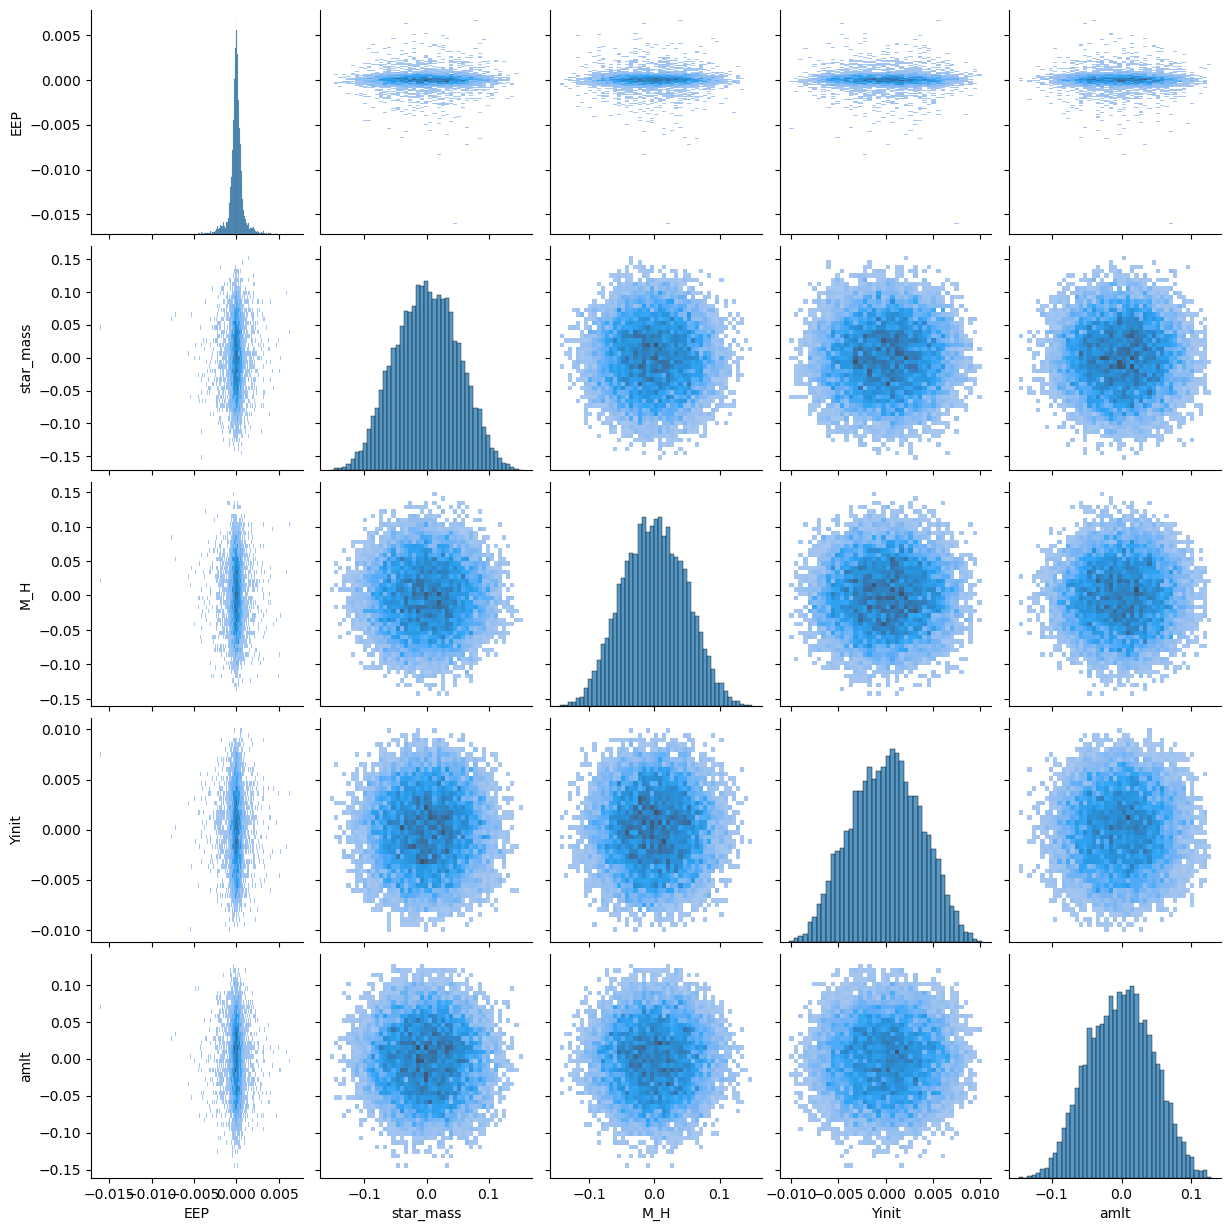

In [269]:
sns.pairplot(features_error, kind="hist", diag_kind="hist")

In [270]:
features_error.quantile([.01, .16, .5, .84, .99])

,EEP,star_mass,M_H,Yinit,amlt
0.01,-0.002808,-0.111046,-0.102820,-0.007706,-0.100930
0.16,-0.000488,-0.051887,-0.049363,-0.003820,-0.049276
0.50,-0.000006,0.001040,-0.000197,0.000138,-0.000175
0.84,0.000471,0.053376,0.049545,0.003889,0.047058
0.99,0.002467,0.111523,0.105288,0.007808,0.099842


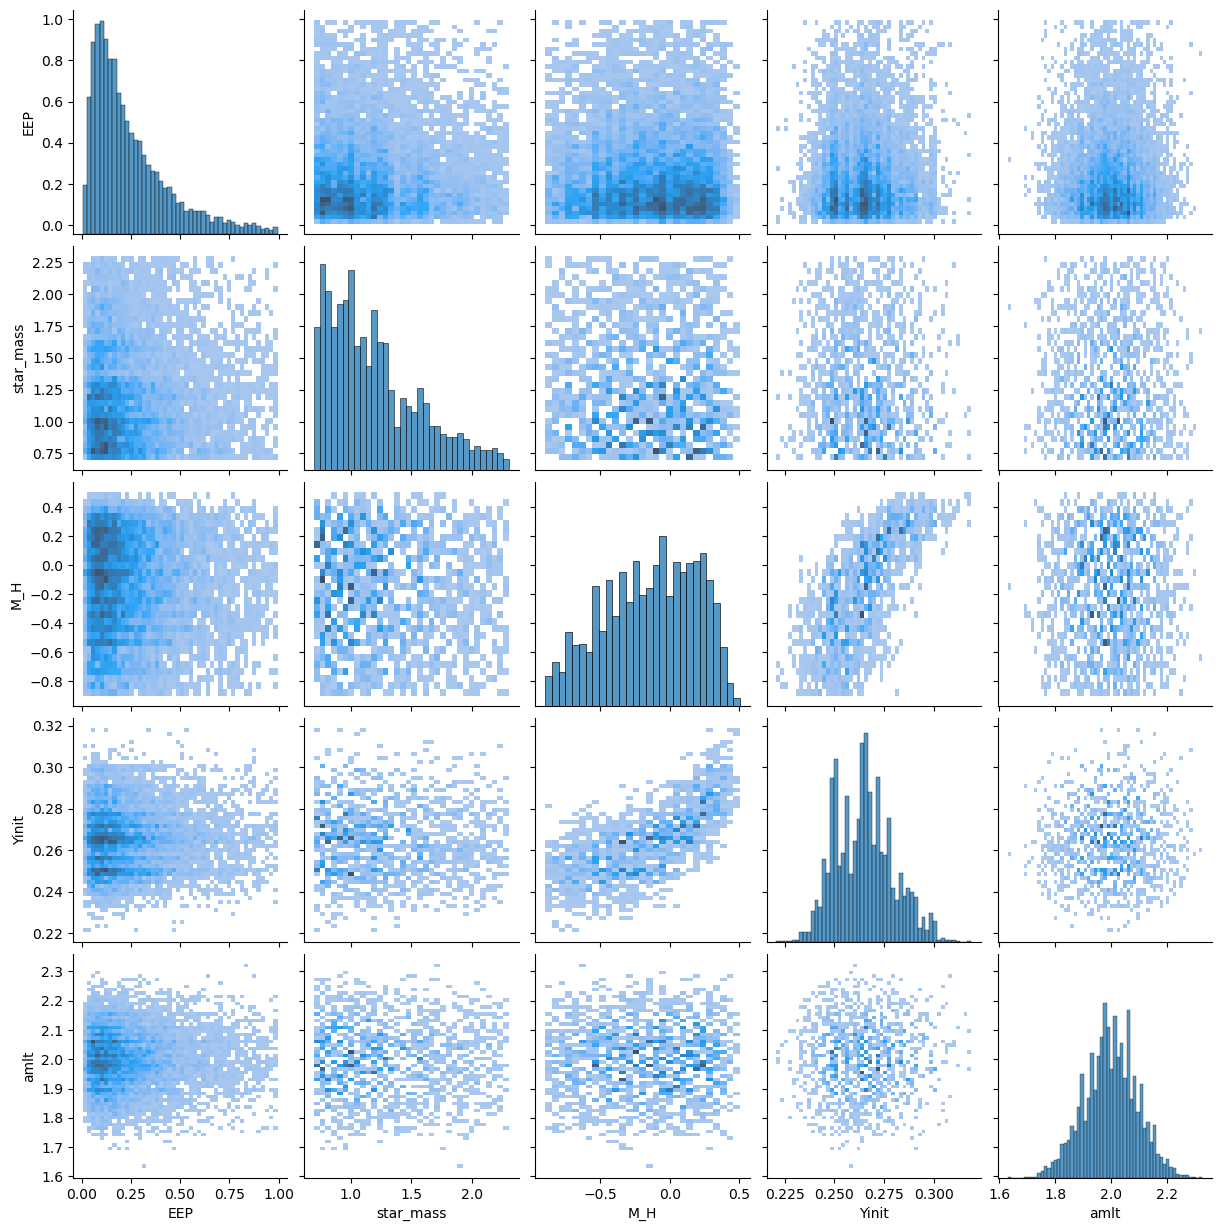

In [271]:
sns.pairplot(df[features].iloc[i], kind="hist", diag_kind="hist");

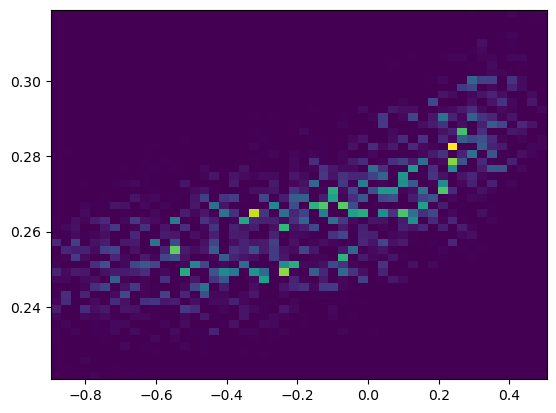

In [272]:
fig, ax = plt.subplots()
ax.hist2d(df.M_H.iloc[i], df.Yinit.iloc[i], bins=50);

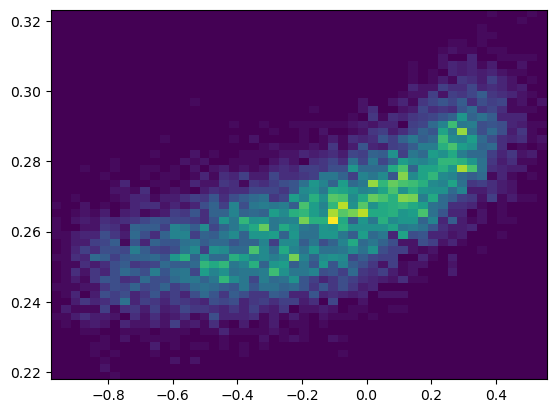

In [273]:
fig, ax = plt.subplots()

mh = df.M_H.iloc[i] + 0.05 * rng.normal(size=size[0])
yi = df.Yinit.iloc[i] + 0.005 * rng.normal(size=size[0])
ax.hist2d(mh, yi, bins=50);

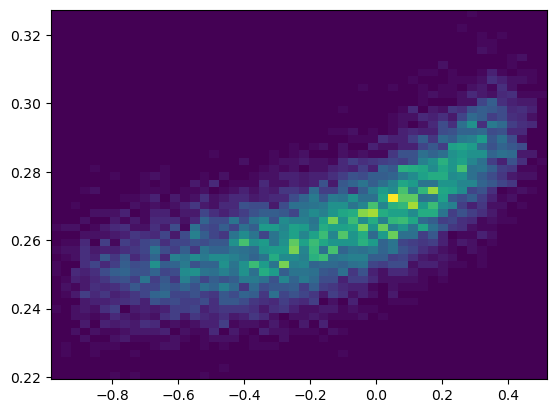

In [274]:
fig, ax = plt.subplots()
ax.hist2d(x[:, 2] + 0.05 * rng.normal(size=size[0]), x[:, 3] + 0.005 * rng.normal(size=size[0]), bins=50);

In [275]:
unique, counts = np.unique(i, return_counts=True)

In [276]:
unique[counts > 1].shape

(423,)

In [277]:
unique[counts > 2].shape

(22,)

In [278]:
unique[counts > 3].shape

(3,)

In [284]:
from scipy.interpolate import LinearNDInterpolator

In [298]:
train.shape[0]/200

24915.49

In [312]:
linear_interpolator = LinearNDInterpolator(train[features].iloc[:100000], train[labels].iloc[:100000], rescale=True)

In [313]:
interp_labels = linear_interpolator(test[features].iloc[:1000])

In [316]:
import pickle

In [317]:
with open("interpolated_train.p", "wb") as file:
    pickle.dump(linear_interpolator, file)

In [314]:
err = 10**interp_labels - 10**test[labels].iloc[:1000]

In [315]:
err.quantile([.16, .5, .84])

,log_star_age,log_Teff,log_radius,log_Dnu_freq_o
0.16,-4.755539e+07,-45.349759,-0.050801,-0.622723
0.50,-4.275117e+05,-2.077410,-0.000175,-0.000010
0.84,3.233511e+06,29.767117,0.032380,0.816165
